In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import segmentation, future
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from src.dataset import Dataset
import torch.utils.data
import torch
import wandb
import seaborn as sns
import numpy as np
import pandas as pd
import os


In [2]:
file_name_zueri = r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
# file_name_zueri = r'C:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'
random_state = 123
np.random.seed(random_state)


os.environ["WANDB_SILENT"] = "true"

def setup_wandb_run(
    project_name: str,
    run_group: str,
    fold: int,
    model_architecture: str,
    batchsize: int,
    seed:int
):
    """
    Sets a new run up (used for k-fold)
    :param str project_name: Name of the project in wandb.
    :param str run_group: Name of the project in wandb.
    :param str fold: number of the executing fold
    :param str model_architecture: Modeltype (architectur) of the model
    :param int batchsize
    :param int seed
    """
    # init wandb
    run = wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project=project_name,
        entity="tmandelz",
        name=f"{fold}-Fold",
        group=run_group,
        config={
            "model architecture": model_architecture,
            "batchsize": batchsize,
            "seed":seed
        },
    )
    return run

def load_data_fold(fold:int=1,mode:str='train',file_name_zueri:str=r'D:\Temp\AgroLuege\raw_data\ZueriCrop\ZueriCrop.hdf5'):
    traindataset= Dataset(file_name_zueri, 0.0, mode, False, fold, "labels.csv",
                      num_channel=4,time_downsample_factor=2, apply_cloud_masking=False,seed=random_state)
    traindataloader = torch.utils.data.DataLoader(traindataset, batch_size=100, shuffle=True, num_workers=0)
    # Initialize an empty list to store batches
    all_data_input = []
    all_data_target = []

    # Iterate through the DataLoader
    for batch in traindataloader:
        input, _, target_2, _ = batch

        all_data_input.append(input)
        all_data_target.append(target_2)

    # Concatenate all batches into a single tensor along the batch dimension (dim=0)
    input_train = torch.cat(all_data_input, dim=0)
    target_train = torch.cat(all_data_target, dim=0)
    return input_train,target_train


def prepare_data_fold(input_train,target_train):
    reshape_factor = len(input_train) // 10 
    input_train= input_train[0:reshape_factor*10]
    target_train = target_train[0:reshape_factor*10]
    reshaped_tensor_train = input_train.reshape(24*reshape_factor, 24*10, 4)
    reshaped_target_train = target_train.reshape(24*reshape_factor, 24*10)

    return reshaped_tensor_train,reshaped_target_train

def fit_rf(reshaped_tensor_train,reshaped_target_train,class_weights:dict={0: 1, 1: 1, 2:1,3:1,4:1,5:1}):
    
    clf = RandomForestClassifier(n_estimators=5,n_jobs=-1,class_weight=class_weights)
    clf = future.fit_segmenter(reshaped_target_train, reshaped_tensor_train, clf)
    y_pred = future.predict_segmenter(reshaped_tensor_train, clf)
    return y_pred

def evaluate_log(reshaped_target_train,y_pred,wandbrun,verbose:bool=False,
                 class_names_cm =["0_unknown","Field crops","Forest","Grassland","Orchards","Special crops"]):
    
    accuracy = accuracy_score(reshaped_target_train.numpy().ravel(), y_pred.ravel())
    conf_matrix = confusion_matrix(reshaped_target_train.numpy().ravel(), y_pred.ravel())
    f1score = f1_score(reshaped_target_train.numpy().ravel(), y_pred.ravel(), average=None)
    # Log the F1 scores for each class
    f1_scores_dict = {"F1-Score_"+class_names_cm[i]: f1score[i] for i in range(len(f1score))}
    wandbrun.log(f1_scores_dict)
    if verbose:
        print("Accuracy:", accuracy)
        print("f1scores:", f1_scores_dict)
    wandbrun.log({'accuracy': accuracy})
    wandbrun.log(f1_scores_dict)

    plt.figure(figsize=(12, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                cbar=False, xticklabels=class_names_cm,
                yticklabels=class_names_cm)
    wandbrun.log({"confusion_matrix": wandb.Image(plt)})
    plt.close()
    wandb.finish()

In [3]:
for fold in range(1,6):
    # init the wandb run
    run = setup_wandb_run(project_name="dlbs-crop-segmentation",
                            run_group="RandomForest-Baseline",
                            fold=fold, model_architecture="RandomForest",
                            batchsize='Full',seed=random_state)
    input_train,target_train = load_data_fold(fold=fold)
    reshaped_tensor_train,reshaped_target_train = prepare_data_fold(input_train,target_train)
    y_pred = fit_rf(reshaped_tensor_train,reshaped_target_train)

    evaluate_log(reshaped_target_train,y_pred,run,verbose=True)

5fold:  1   Mode:  train
Dataset size:  27977
Valid dataset size:  1086
Sequence length:  142
Spatial size:  (24, 24)
Number of classes:  52
Number of classes - local-1:  6
Number of classes - local-2:  20
Accuracy: 0.9051134902263375
f1scores: {'F1-Score_0_unknown': 0.0, 'F1-Score_Field crops': 0.9338455528063551, 'F1-Score_Forest': 0.9285714285714286, 'F1-Score_Grassland': 0.9003982933661108, 'F1-Score_Orchards': 0.8211575980923478, 'F1-Score_Special crops': 0.8286604361370716}


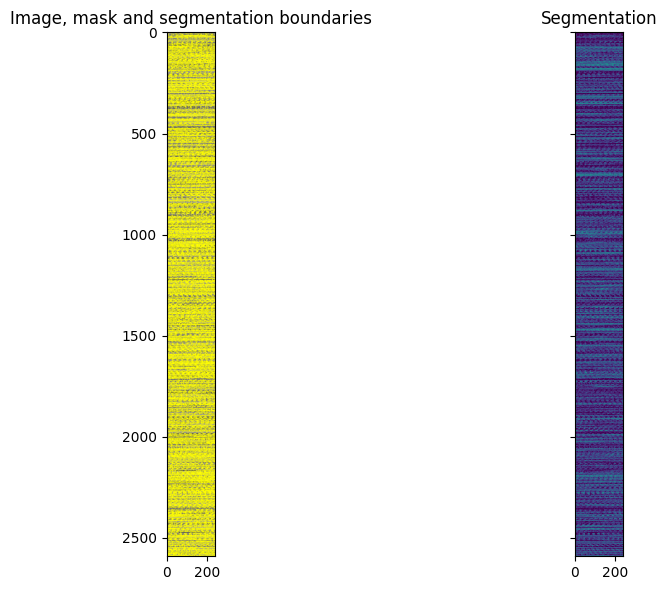

In [4]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 6))
ax[0].imshow(segmentation.mark_boundaries(reshaped_tensor_train[:,:,1:4].numpy(), y_pred, mode='thick'))
# ax[0].contour(reshaped_target.numpy())
ax[0].set_title('Image, mask and segmentation boundaries')
ax[1].imshow(y_pred)
ax[1].set_title('Segmentation')
fig.tight_layout()